# Example case of simulating observations of a cluster with multiple pointings #

This thread shows how to use _M2_ProposalTools_ to simulate observations of a target.

In [1]:
### Useful libraries
import numpy as np
import astropy.units as u
from astropy.io import fits 
#### Modules within our library
import M2_ProposalTools.WorkHorse as WH
import M2_ProposalTools.MakeRMSmap as MRM
import M2_ProposalTools.ModelFitting as MF

Supply an output directory.

In [2]:
outdir="/home/data/MUSTANG2/SimulatedObservations/LightWeight/"

Let's define some options for the input cluster, mapping parameters, and scanning strategy

If an entry in offsets is greater than zero, then the scan strategy is taken to be a set of four scans which are offset by the respective distance, in arcminutes, from the central pointing towards: (1) the west, (2) north, (3) east, and (4) south.

In [3]:
fromM200 = False
verbose = False

if fromM200:
    lgM200   = 15.1                   # Log_10 M200
    M200     = np.power(10, lgM200)   # Now in normal units
    ##How to go to M500? Various numbers in the literature, but we don't need to be too precise.
    M5_14    = 0.7 * M200 / 1e14      # Crude approximation (in 10^14 solar masses)
else:
    M5_14    = 4.0                    # We leave this separate as we'll want to reference this below

M500 = M5_14*1e14 * u.M_sun

if verbose:
    print(M500/1e14)                   # in 1e14

In [4]:
z        = 0.4                     # The redshift
pixsize  = 3.0                     # Pixel size, in arcseconds. For MUSTANG-2, between 2" and 4" is fine.

times    = [10,10]                 # A list of time per scan strategy, in hours
ptgs     = [[180,45.0],[180,45.0]] # A list of centroid pairs (RA,Dec) in degrees
sizes    = [3.5,3.5]               # Scan sizes, in arcminutes
offsets  = [1.5,0]                 # Pointing offsets, in arcminutes.

Assuming we don't already have a map of a cluster, I will make a map (with astrometry information) of a cluster.
We'll assume a spherical A10 cluster, with a pressure profile like the "disturbed" cluster subsample.

We'll say that the cluster center is the same as our pointings above. We'll further let our map go out to $3 R_{500}$, such that a given side is $6 R_{500}$. 

For use with MUSTANG-2 simulation, we'll want the input map to be beam-convolved, so we set the option to have that already done.
Finally, we can convert from Compton y to microKelvin (Rayleigh-Jeans) by setting conv2uK=True. This is nice simply because our RMS values for the sensitivity maps will be in microKelvin.

In [5]:
SkyHDU  = WH.make_A10_hdu(z,M500,pixsize,Dist=True,beamConvolve=True,conv2uK=True,center=[180,45.0],nR500=3.0)

The above image is what MUSTANG-2 would see if data processing imparted no filtering effects. Unfortunately, it does, and so we combined the filtering effects with the sensitivity mapmaking in the following routine. It returns two HDULists. The first HDUList has a filtered map and a corresponding weight map, where the weight map is the inverse variance. The second HDUList is the same, but the filtered map has an additional smoothing. This smoothing is the standard smoothing applied to final MIDAS maps; it is with this smoothing that the inverse variance maps, as calculated, are appropriate comparisons.

In [6]:
FilterHDU,SmoothHDU = WH.lightweight_simobs_hdu(SkyHDU,ptgs=ptgs,sizes=sizes,times=times,offsets=offsets,center=None)

Depending on what you want to track, this adds some information to the filenames

In [7]:
pixstr = "{:.1f}".format(pixsize).replace(".","p")
zstr   = "{:.1f}".format(z).replace(".","z")
Mstr   = "{:.1f}".format(M5_14).replace(".","m")
sss    = ["{:.1f}".format(mysz).replace(".","s") for mysz in sizes]
sts    = ["{:.1f}".format(mytime).replace(".","h") for mytime in times]
ssstr  = "_".join(sss)
ststr  = "_".join(sts)
InputStr = "_".join([zstr,Mstr,ssstr,ststr,pixstr])

Saving to fits files may be desirable.

In [8]:
Skyname = "SimulatedSky_"+InputStr+".fits"
SkyHDU.writeto(outdir+Skyname,overwrite=True)

filename = "SimulatedObs_Unsmoothed_"+InputStr+".fits"
FilterHDU.writeto(outdir+filename,overwrite=True)
filename2 = "SimulatedObs_Smoothed_"+InputStr+".fits"
SmoothHDU.writeto(outdir+filename2,overwrite=True)

Let's plot the radial profiles so you that the filtering may be more evident.

Smoothed Mock Obs-- Peak in binned profile:  -77.76438354989634  ; peak in map:  -78.9640668583741
Mock Obs-- Peak in binned profile:  -85.86389597908061  ; peak in map:  -87.32576762257253
Bm. Conv. Sky-- Peak in binned profile:  -85.86389597908061  ; peak in map:  -226.01699664913238


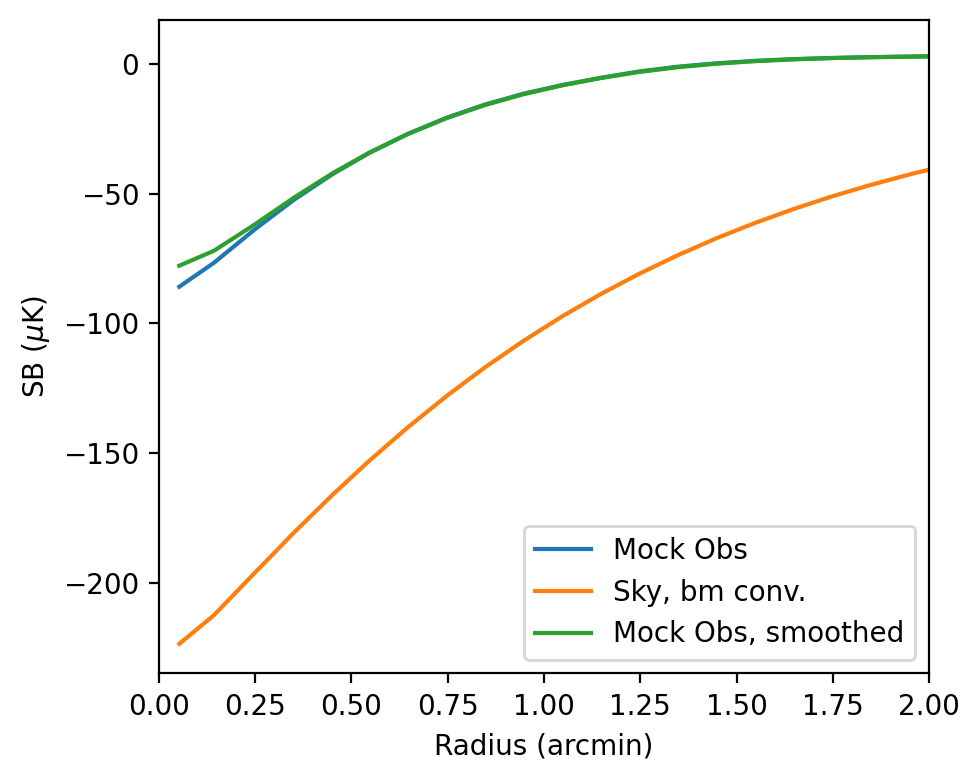

In [9]:
SBfn = "SimulatedObs_SBprofiles_"+InputStr+".png"
MF.plot_SB_profiles(FilterHDU,SkyHDU,outdir,SBfn,prntPk=True,addHDU=SmoothHDU,addLabel="Mock Obs, smoothed")

And again, we can generate a sensitivity map. For this example, the very center of the map gets down to 14.3 $\mu$K. This is close to a 10$\sigma$ detection of the peak.

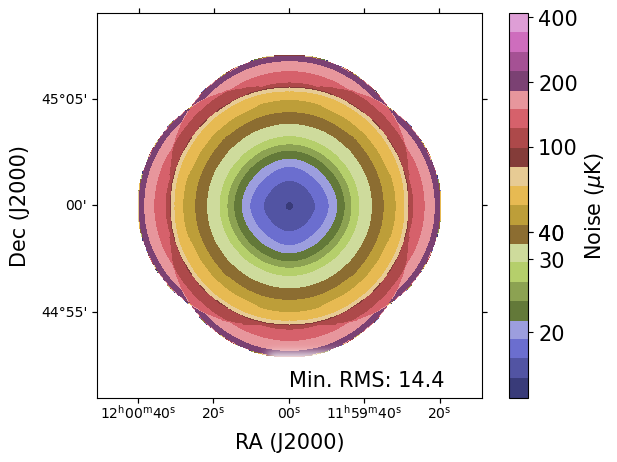

In [10]:
pngname  = "SimulatedObservations_"+InputStr+"_RMSimage.png"
vmin     = 12.5  # uK
vmax     = 420.0 # uK
MRM.plot_rms_general(SmoothHDU,outdir+pngname,ncnts=0,vmin=vmin,vmax=vmax,prntinfo=True)